In [29]:
### SETUP ###
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation

### SET DISPLAY PARAMETERS FOR DATAFRAMES AND PLOTS ###
pd.set_option('display.max_rows', 50)
plt.rcParams['figure.figsize'] = [3.5, 9]
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "Arial"

# 2 variables
# Phenotype: Normal, Early Death, Bloated
# Alleles: WT, In-frame, frameshift

In [2]:
### READ IN METADATA LABELING INDIVIDUAL SAMPLE PHENOTYPES ###
# Must be .csv
# Must have a column "Sample Name" with sample names
# Must have a column "Phenotype" (TODO: change to generic label)

phenotype_metadata_csv = "genopy_lox5/data_lox5/batchAC_phenotype_metadata.csv"
batch_0AC_phenotype_metadata = pd.read_csv(phenotype_metadata_csv)
batch_0AC_phenotype_metadata

,Sample Name,Phenotype
0,A1,Normal
1,A2,Normal
2,A3,Bloated
3,A4,Normal
4,A5,Bloated
...,...,...
71,11-lox5_INJ_MED_11_C02_012.fsa,Normal
72,12-lox5_INJ_NONE_12_D02_010.fsa,Normal
73,13-lox5_INJ_NONE_13_E02_008.fsa,Normal
74,14-lox5_INJ_NONE_14_F02_006.fsa,Normal


In [3]:
### READ IN METADATA LABELING INDIVIDUAL SAMPLE gRNAs ###
# Must be .csv
# Must have a column "Sample Name" with sample names
# Must have a column "gRNA" (TODO: change to generic label)

grna_metadata_csv = "genopy_lox5/data_lox5/batchAC_gRNA_metadata.csv"
batch_0AC_grna_metadata = pd.read_csv(grna_metadata_csv)
batch_0AC_grna_metadata

,Sample Name,gRNA
0,A1,1
1,A2,1
2,A3,1
3,A4,1
4,A5,1
...,...,...
71,11-lox5_INJ_MED_11_C02_012.fsa,2
72,12-lox5_INJ_NONE_12_D02_010.fsa,2
73,13-lox5_INJ_NONE_13_E02_008.fsa,2
74,14-lox5_INJ_NONE_14_F02_006.fsa,2


In [4]:
### READ IN ALL DATA ###
# For Batches A/B/C
exported_data_1 = pd.read_csv("genopy_lox5/data_lox5/lox5_Genotyping_Batches_ABCUninj_021820_2020-02-25_18558_Samples_All.csv")
exported_data_2 = pd.read_csv("genopy_lox5/data_lox5/Lox5T3 genotyping experiment sets A_Samples_1-50.csv")
exported_data_3 = pd.read_csv("genopy_lox5/data_lox5/Lox5T3 genotyping experiment sets A_Samples_51-79.csv")
all_data_123 = pd.concat([exported_data_1, exported_data_2, exported_data_3])
# Insert column with sample name for Batches A/B/C
all_data_123.insert(0, "Sample Name", all_data_123["Sample Filename"].apply(lambda filename : filename.split("-")[1].split("_")[0]))
# SPECIFIC TO THIS NOTEBOOK: Remove Batch B from consideration
all_data_123 = all_data_123[["B" not in sample_name for sample_name in list(all_data_123["Sample Name"])]]


# For Batches WT/NONE/MED/SEV
all_data_wnms = pd.read_csv("genopy_lox5/data_lox5/lox5 Genotyping Analysis 090619_2020-02-28_152143_All_Samples.csv")
# Insert column with sample name for Batches WT/NONE/MED/SEV
all_data_wnms.insert(0, "Sample Name", all_data_wnms["Sample Filename"]) 

In [5]:
### MERGE (CONCATENATE) ALL DATA ###
all_exported_data = pd.concat([all_data_123, all_data_wnms])

### FILTER FOR DESIRED PEAKS ###
# Selects only the BLUE dye color peaks
all_exported_data = all_exported_data[all_exported_data["Dye Color"] == "BLUE"]

In [6]:
### ADD COLUMN WITH ROUNDED PEAK SIZE ###
# Rounds the "Size" values and adds new column; removes "*" in front of "size standard" peak lengths
def round_and_convert(size):
    if "*" in size:
        size = size[1:]
    return round(float(size))


all_exported_data.insert(1, "Rounded Peak Size (bp)", all_exported_data["Size"].apply(round_and_convert))

In [7]:
#Isolate peaks given set constraints on minimum peak height and minimum bp
min_bp = 50
min_height = 750

all_exported_data = all_exported_data[all_exported_data["Rounded Peak Size (bp)"] >= min_bp]
all_exported_data = all_exported_data[all_exported_data["Height"] >= min_height]

# COMMENTED OUT IN THIS NOTEBOOK
wt_peak_bp_1 = None
wt_peak_bp_2 = 297

all_exported_data.insert(2, "WT Peak (T/F)", all_exported_data["Rounded Peak Size (bp)"].apply(lambda size : size in (wt_peak_bp_1, wt_peak_bp_2)))

#spurious_peaks = all_exported_data
#spurious_peaks.insert(0, "Spurious Peak", spurious_peaks["Rounded Peak Size (bp)"].apply(lambda size : size in (185, 223, 245, 246, 247)))
#spurious_peaks.insert(0, "Spurious Peak", spurious_peaks["Rounded Peak Size (bp)"].apply(lambda size : size in (185, 223, 245, 246, 247)))

#TODO: Cleanup for succintness
#REMOVE SPURIOUS PEAKS (BP DETERMINED BY MANUAL REVIEW)
all_exported_data = all_exported_data[all_exported_data["Rounded Peak Size (bp)"] != 195]
all_exported_data = all_exported_data[all_exported_data["Rounded Peak Size (bp)"] != 223]
all_exported_data = all_exported_data[all_exported_data["Rounded Peak Size (bp)"] != 245]
all_exported_data = all_exported_data[all_exported_data["Rounded Peak Size (bp)"] != 246]
all_exported_data = all_exported_data[all_exported_data["Rounded Peak Size (bp)"] != 247]
all_exported_data

,Sample Name,Rounded Peak Size (bp),WT Peak (T/F),Sample Filename,Dye Color,"Dye, Sample Peak",Size,Height,Area (Data Point),Area (Base Pairs),Data Point,Begin Point (Data Point),End Point (Data Point),Begin Point (Base Pairs),End Point (Base Pairs),Unnamed: 12
1,C1,292,False,01-C1_A01_015.fsa,BLUE,"B, 81",291.82,916.0,6509.0,480.10,4520.0,4512.0,4525.0,291.23,292.19,NaN
9,C1,297,True,01-C1_A01_015.fsa,BLUE,"B, 84",296.98,4751.0,31321.0,2306.25,4590.0,4581.0,4600.0,296.32,297.72,NaN
16,C1,75,False,01-C1_A01_015.fsa,BLUE,"B, 37",75.12,1677.0,10050.0,851.03,1725.0,1717.0,1736.0,74.44,76.05,NaN
34,C1,78,False,01-C1_A01_015.fsa,BLUE,"B, 39",77.65,2618.0,16685.0,1404.27,1755.0,1747.0,1761.0,76.98,78.16,NaN
44,C1,303,False,01-C1_A01_015.fsa,BLUE,"B, 89",303.07,17680.0,125332.0,9186.71,4673.0,4663.0,4693.0,302.34,304.54,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,09-lox5_INJ_MED_9_A02_016.fsa,306,False,09-lox5_INJ_MED_9_A02_016.fsa,BLUE,"B, 75",305.98,2289.0,14612.0,1187.02,4269.0,4260.0,4278.0,305.25,306.71,NaN
1316,10-lox5_INJ_MED_10_B02_014.fsa,298,False,10-lox5_INJ_MED_10_B02_014.fsa,BLUE,"B, 75",298.13,801.0,6852.0,555.79,4184.0,4180.0,4195.0,297.81,299.03,NaN
1343,10-lox5_INJ_MED_10_B02_014.fsa,531,False,10-lox5_INJ_MED_10_B02_014.fsa,BLUE,"B, 85",531.10,908.0,12068.0,1041.28,7002.0,6987.0,7040.0,529.81,534.38,NaN
1347,10-lox5_INJ_MED_10_B02_014.fsa,556,False,10-lox5_INJ_MED_10_B02_014.fsa,BLUE,"B, 87",555.95,17088.0,206988.0,18570.93,7285.0,7256.0,7314.0,553.35,558.56,NaN


In [8]:
# CREATE A DATAFRAME OF ALL 0'S FOR APPENDING TO ACTUAL DATA TO ENSURE GROUPY PRESERVES ALL THREE ALLELE TYPES

sample_names = batch_0AC_phenotype_metadata["Sample Name"]
zero_filler_data = pd.DataFrame()

for idx in np.arange(0, 3):
    curr_placeholder_label = ("Wild-type", "Inframe", "Frameshift")[idx]
    curr_placeholder_df = pd.DataFrame(0, index = np.arange(len(sample_names)), columns = all_exported_data.columns)
    curr_placeholder_df["Sample Name"] = sample_names
    curr_placeholder_df["Allele Categorization"] = curr_placeholder_label
    zero_filler_data = pd.concat([zero_filler_data, curr_placeholder_df])
    
zero_filler_data = zero_filler_data.merge(batch_0AC_phenotype_metadata, left_on = "Sample Name", right_on = "Sample Name")
zero_filler_data

,Sample Name,Rounded Peak Size (bp),WT Peak (T/F),Sample Filename,Dye Color,"Dye, Sample Peak",Size,Height,Area (Data Point),Area (Base Pairs),Data Point,Begin Point (Data Point),End Point (Data Point),Begin Point (Base Pairs),End Point (Base Pairs),Unnamed: 12,Allele Categorization,Phenotype
0,A1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wild-type,Normal
1,A1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Inframe,Normal
2,A1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Frameshift,Normal
3,A2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wild-type,Normal
4,A2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Inframe,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,14-lox5_INJ_NONE_14_F02_006.fsa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Inframe,Normal
224,14-lox5_INJ_NONE_14_F02_006.fsa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Frameshift,Normal
225,15-lox5_INJ_NONE_15_G02_004.fsa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wild-type,Normal
226,15-lox5_INJ_NONE_15_G02_004.fsa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Inframe,Normal


In [9]:
### LABELS EACH READ WITH CORRESPONDING INDIVIDUAL PHENOTYPE BASED ON METADATA ###
all_exported_data = all_exported_data.merge(batch_0AC_phenotype_metadata, left_on = "Sample Name", right_on = "Sample Name")
all_exported_data

,Sample Name,Rounded Peak Size (bp),WT Peak (T/F),Sample Filename,Dye Color,"Dye, Sample Peak",Size,Height,Area (Data Point),Area (Base Pairs),Data Point,Begin Point (Data Point),End Point (Data Point),Begin Point (Base Pairs),End Point (Base Pairs),Unnamed: 12,Phenotype
0,C1,292,False,01-C1_A01_015.fsa,BLUE,"B, 81",291.82,916.0,6509.0,480.10,4520.0,4512.0,4525.0,291.23,292.19,NaN,Early Death
1,C1,297,True,01-C1_A01_015.fsa,BLUE,"B, 84",296.98,4751.0,31321.0,2306.25,4590.0,4581.0,4600.0,296.32,297.72,NaN,Early Death
2,C1,75,False,01-C1_A01_015.fsa,BLUE,"B, 37",75.12,1677.0,10050.0,851.03,1725.0,1717.0,1736.0,74.44,76.05,NaN,Early Death
3,C1,78,False,01-C1_A01_015.fsa,BLUE,"B, 39",77.65,2618.0,16685.0,1404.27,1755.0,1747.0,1761.0,76.98,78.16,NaN,Early Death
4,C1,303,False,01-C1_A01_015.fsa,BLUE,"B, 89",303.07,17680.0,125332.0,9186.71,4673.0,4663.0,4693.0,302.34,304.54,NaN,Early Death
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,09-lox5_INJ_MED_9_A02_016.fsa,294,False,09-lox5_INJ_MED_9_A02_016.fsa,BLUE,"B, 68",293.75,30916.0,200557.0,16288.79,4118.0,4109.0,4127.0,293.02,294.48,NaN,Normal
443,09-lox5_INJ_MED_9_A02_016.fsa,297,True,09-lox5_INJ_MED_9_A02_016.fsa,BLUE,"B, 70",297.00,8483.0,57684.0,4680.80,4158.0,4148.0,4168.0,296.19,297.81,NaN,Normal
444,09-lox5_INJ_MED_9_A02_016.fsa,303,False,09-lox5_INJ_MED_9_A02_016.fsa,BLUE,"B, 73",302.90,1240.0,9700.0,783.07,4231.0,4222.0,4235.0,302.17,303.22,NaN,Normal
445,09-lox5_INJ_MED_9_A02_016.fsa,304,False,09-lox5_INJ_MED_9_A02_016.fsa,BLUE,"B, 74",303.87,32575.0,237158.0,19194.15,4243.0,4235.0,4255.0,303.22,304.84,NaN,Normal


In [10]:
### LABELS EACH READ AS WT, FRAMESHIFT, OR INFRAME ###
wt_bp = (297, None)
if_bp = np.arange(0, 1000, 3)

def check_allele(size):
    if size in wt_bp:
        return "Wild-type"
    elif size in if_bp:
        return "Inframe"
    else:
        return "Frameshift"
    
all_exported_data.insert(0, "Allele Categorization", all_exported_data["Rounded Peak Size (bp)"].apply(check_allele))
all_exported_data

,Allele Categorization,Sample Name,Rounded Peak Size (bp),WT Peak (T/F),Sample Filename,Dye Color,"Dye, Sample Peak",Size,Height,Area (Data Point),Area (Base Pairs),Data Point,Begin Point (Data Point),End Point (Data Point),Begin Point (Base Pairs),End Point (Base Pairs),Unnamed: 12,Phenotype
0,Frameshift,C1,292,False,01-C1_A01_015.fsa,BLUE,"B, 81",291.82,916.0,6509.0,480.10,4520.0,4512.0,4525.0,291.23,292.19,NaN,Early Death
1,Wild-type,C1,297,True,01-C1_A01_015.fsa,BLUE,"B, 84",296.98,4751.0,31321.0,2306.25,4590.0,4581.0,4600.0,296.32,297.72,NaN,Early Death
2,Inframe,C1,75,False,01-C1_A01_015.fsa,BLUE,"B, 37",75.12,1677.0,10050.0,851.03,1725.0,1717.0,1736.0,74.44,76.05,NaN,Early Death
3,Inframe,C1,78,False,01-C1_A01_015.fsa,BLUE,"B, 39",77.65,2618.0,16685.0,1404.27,1755.0,1747.0,1761.0,76.98,78.16,NaN,Early Death
4,Inframe,C1,303,False,01-C1_A01_015.fsa,BLUE,"B, 89",303.07,17680.0,125332.0,9186.71,4673.0,4663.0,4693.0,302.34,304.54,NaN,Early Death
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,Inframe,09-lox5_INJ_MED_9_A02_016.fsa,294,False,09-lox5_INJ_MED_9_A02_016.fsa,BLUE,"B, 68",293.75,30916.0,200557.0,16288.79,4118.0,4109.0,4127.0,293.02,294.48,NaN,Normal
443,Wild-type,09-lox5_INJ_MED_9_A02_016.fsa,297,True,09-lox5_INJ_MED_9_A02_016.fsa,BLUE,"B, 70",297.00,8483.0,57684.0,4680.80,4158.0,4148.0,4168.0,296.19,297.81,NaN,Normal
444,Inframe,09-lox5_INJ_MED_9_A02_016.fsa,303,False,09-lox5_INJ_MED_9_A02_016.fsa,BLUE,"B, 73",302.90,1240.0,9700.0,783.07,4231.0,4222.0,4235.0,302.17,303.22,NaN,Normal
445,Frameshift,09-lox5_INJ_MED_9_A02_016.fsa,304,False,09-lox5_INJ_MED_9_A02_016.fsa,BLUE,"B, 74",303.87,32575.0,237158.0,19194.15,4243.0,4235.0,4255.0,303.22,304.84,NaN,Normal


In [11]:
# CONCATENATE THE FILLER ZERO DF AND ACTUAL DATA DF
all_data_with_zeroes = pd.concat([all_exported_data, zero_filler_data])
all_data_with_zeroes

/Users/David/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,Allele Categorization,Area (Base Pairs),Area (Data Point),Begin Point (Base Pairs),Begin Point (Data Point),Data Point,Dye Color,"Dye, Sample Peak",End Point (Base Pairs),End Point (Data Point),Height,Phenotype,Rounded Peak Size (bp),Sample Filename,Sample Name,Size,Unnamed: 12,WT Peak (T/F)
0,Frameshift,480.10,6509.0,291.23,4512.0,4520.0,BLUE,"B, 81",292.19,4525.0,916.0,Early Death,292,01-C1_A01_015.fsa,C1,291.82,NaN,0
1,Wild-type,2306.25,31321.0,296.32,4581.0,4590.0,BLUE,"B, 84",297.72,4600.0,4751.0,Early Death,297,01-C1_A01_015.fsa,C1,296.98,NaN,1
2,Inframe,851.03,10050.0,74.44,1717.0,1725.0,BLUE,"B, 37",76.05,1736.0,1677.0,Early Death,75,01-C1_A01_015.fsa,C1,75.12,NaN,0
3,Inframe,1404.27,16685.0,76.98,1747.0,1755.0,BLUE,"B, 39",78.16,1761.0,2618.0,Early Death,78,01-C1_A01_015.fsa,C1,77.65,NaN,0
4,Inframe,9186.71,125332.0,302.34,4663.0,4673.0,BLUE,"B, 89",304.54,4693.0,17680.0,Early Death,303,01-C1_A01_015.fsa,C1,303.07,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,Inframe,0.00,0.0,0.00,0.0,0.0,0,0,0.00,0.0,0.0,Normal,0,0,14-lox5_INJ_NONE_14_F02_006.fsa,0,0.0,0
224,Frameshift,0.00,0.0,0.00,0.0,0.0,0,0,0.00,0.0,0.0,Normal,0,0,14-lox5_INJ_NONE_14_F02_006.fsa,0,0.0,0
225,Wild-type,0.00,0.0,0.00,0.0,0.0,0,0,0.00,0.0,0.0,Normal,0,0,15-lox5_INJ_NONE_15_G02_004.fsa,0,0.0,0
226,Inframe,0.00,0.0,0.00,0.0,0.0,0,0,0.00,0.0,0.0,Normal,0,0,15-lox5_INJ_NONE_15_G02_004.fsa,0,0.0,0


In [12]:
all_allele_all_phenotype = all_data_with_zeroes.groupby(["Sample Name", "Phenotype", "Allele Categorization"]).sum()
all_allele_all_phenotype_proportions = all_allele_all_phenotype / (all_allele_all_phenotype.groupby(level = 0).sum())
all_allele_all_phenotype_proportions

Area (Base Pairs)  \
Sample Name                   Phenotype   Allele Categorization                      
01-lox5_INJ_SEV_1_A01_015.fsa Bloated     Frameshift                      0.926289   
                                          Inframe                         0.018441   
                                          Wild-type                       0.055270   
02-lox5_INJ_SEV_2_B01_013.fsa Bloated     Frameshift                      0.739771   
                                          Inframe                         0.195165   
...                                                                            ...   
C8                            Early Death Inframe                         0.101538   
                                          Wild-type                       0.187905   
C9                            Early Death Frameshift                      0.680529   
                                          Inframe                         0.275704   
                                          Wild-type                       0.043767   

                                                                 Area (Data Point)  \
Sample Name                   Phenotype   Allele Categorization                      
01-lox5_INJ_SEV_1_A01_015.fsa Bloated     Frameshift                      0.926035   
                                          Inframe                         0.018356   
                                          Wild-type                       0.055609   
02-lox5_INJ_SEV_2_B01_013.fsa Bloated     Frameshift                      0.739585   
                                          Inframe                         0.195172   
...                                                                            ...   
C8                            Early Death Inframe                         0.102183   
                                          Wild-type                       0.204164   
C9                            Early Death Frameshift                      0.680528   
                                          Inframe                         0.275667   
                                          Wild-type                       0.043806   

                                                                 Begin Point (Base Pairs)  \
Sample Name                   Phenotype   Allele Categorization                             
01-lox5_INJ_SEV_1_A01_015.fsa Bloated     Frameshift                             0.573442   
                                          Inframe                                0.278876   
                                          Wild-type                              0.147682   
02-lox5_INJ_SEV_2_B01_013.fsa Bloated     Frameshift                             0.497464   
                                          Inframe                                0.248732   
...                                                                                   ...   
C8                            Early Death Inframe                                0.366396   
                                          Wild-type                              0.125305   
C9                            Early Death Frameshift                             0.498721   
                                          Inframe                                0.249356   
                                          Wild-type                              0.251923   

                                                                 Begin Point (Data Point)  \
Sample Name                   Phenotype   Allele Categorization                             
01-lox5_INJ_SEV_1_A01_015.fsa Bloated     Frameshift                             0.573172   
                                          Inframe                                0.279783   
                                          Wild-type                              0.147044   
02-lox5_INJ_SEV_2_B01_013.fsa Bloated     Frameshift                             0.497782   
                                          Inframe          

In [13]:
## Normalize/(log of + 1)
def plus_log_normalize(col):
    plus_log_df = np.log(col + 1)
    def normalize(c):
        return np.abs(c - c.min())/(c.max() - c.min())
    return normalize(plus_log_df)

In [14]:
## Logit
def logit(col):
    return np.log(col / (1 - col))

In [15]:
def get_proportions(sample_names, phenotype, allele_categorization):
    # phenotype: list or string
    # allele_categorization: string
    return all_allele_all_phenotype_proportions.loc[pd.IndexSlice[sample_names, phenotype, allele_categorization], ["Area (Base Pairs)"]]["Area (Base Pairs)"]

In [139]:
def box_strip_plot(groups, measure, phenotype_metadata, grna_metadata, color_palette = "Grey", show_legend = True):
    """
    Displays box plot with superimposed strip plot for specified groups and corresponding specified measure.
    Calculates t-test p-value and titles plot accordingly.
    :param groups: List of strings of names of sample groups to be plotted on x-axis. Must be of length greater than 1.
    :param measure: String of allele type whose proportion is to be plotted on y-axis.
    :param phenotype_metadata: String of file path of metadata csv with sample names and phenotype group identifications.
    :param grna_metadata: String of file path of metadata csv with sample names and gRNA identifications.
    :param show_legend: boolean of whether or not to show gRNA legend.
    :param color_palette: String denoting seaborn-compatible color palette.
    :return: none
    """
    if len(groups) <= 1:
        raise ValueError("Must specify more than one group and exactly one measurement.")
        
    ## TODO: Raise error if sample names do not match    
    sample_phenotype_metadata = pd.read_csv(phenotype_metadata).set_index("Sample Name")
    grna_metadata = pd.read_csv(grna_metadata).set_index("Sample Name")
    
    # Initialize variable to store DataFrame of all data
    agg_data = pd.DataFrame()
    agg_data_log_normed = pd.DataFrame()
    
    ## OLD DF STRUCTURE
    # Iterates through provided group(s) and populates agg_data with each grp_data, where grp_data is df formed from
    # calling get_proportions on names of samples corresponding to group, the group, and the desired allele type
    #for grp in groups:
    #    sample_names = sample_metadata[sample_metadata["Phenotype"] == grp].index
    #    grp_data = pd.DataFrame({grp : get_proportions(sample_names, grp, measure)})
    #    if agg_data.empty:
    #        agg_data = grp_data
    #    else:
    #        agg_data = agg_data.merge(grp_data, left_on = "Sample Name", right_on = "Sample Name", how = "outer")
            
    ## NEW DF STRUCTURE
    for grp in groups:
        sample_names = sample_phenotype_metadata[sample_phenotype_metadata["Phenotype"] == grp].index
        
        grp_data = pd.DataFrame(get_proportions(sample_names, grp, measure))
        
        grp_data_proportions = grp_data["Area (Base Pairs)"]
        grp_data_log_normed = grp_data.copy()
        grp_data_log_normed["Normalized Proportion"] = logit(grp_data_proportions)
        
        #DEBUG
        #grp_data.hist()
        #print("Number of samples: " + str(len(grp_data)))
        
        agg_data= pd.concat([agg_data, grp_data])
        agg_data_log_normed = pd.concat([agg_data_log_normed, grp_data_log_normed])
    
    # Label data with gRNA and phenotype by merging with gRNA and phenotype metadata
    agg_data = agg_data.merge(batch_0AC_phenotype_metadata, left_on = "Sample Name", right_on = "Sample Name")
    agg_data = agg_data.merge(batch_0AC_grna_metadata, left_on = "Sample Name", right_on = "Sample Name")
    agg_data = agg_data.rename(columns = {"Area (Base Pairs)" : "Proportion"})
    
    agg_data_log_normed = agg_data_log_normed.merge(batch_0AC_phenotype_metadata, left_on = "Sample Name", right_on = "Sample Name")
    agg_data_log_normed = agg_data_log_normed.merge(batch_0AC_grna_metadata, left_on = "Sample Name", right_on = "Sample Name")
    agg_data_log_normed = agg_data_log_normed.rename(columns = {"Area (Base Pairs)" : "Proportion"})
    
    # Create hist of log of +1 normalized
    #plt.hist(x = "Proportion", data = agg_data)
    
    #DEBUG
    #print(agg_data)
    #print(agg_data_log_normed)
    #print("Number of Samples: " + str(len(agg_data)))
    
    sns.set_context(rc = {'patch.linecolor': 'black'})
    cal_blues = sns.color_palette(["#003262", "#3B7EA1"])
    cal_golds = sns.color_palette(["#FDB515", "#C4820E"])
    cal_greens = sns.color_palette(["#CFDD45", "#B9D3B6"])
    cal_greys = sns.color_palette(["#EEEEEE", "#888888"])
    binary_maxed = sns.color_palette(["#FFFFFF", "#000000"])
    deep_greys = sns.color_palette(["#494949", "#C9C9C9"])
    
    plt.ylim(-0.1, 1.1)
    
    plot = sns.boxplot(x = "Phenotype", y = "Proportion", data = agg_data, showfliers = False, palette = color_palette, showmeans = True, meanline = True,
                       meanprops = dict(linewidth = 1.0, color = "black"))
    plot = sns.swarmplot(x = "Phenotype", y = "Proportion", hue = "gRNA", data = agg_data, marker = "o", size = 6, alpha = 0.85, edgecolor = "black", linewidth = 1.0, palette = deep_greys)
    
    add_stat_annotation(plot, x = "Phenotype", y = "Proportion", data = agg_data, box_pairs=[("Normal", "Bloated")],
                    test="Mann-Whitney", text_format="star", loc="inside", verbose=0)

    plot_title = "Proportion " + measure + " Alleles \n for " + "/".join(groups) + " Samples"
    plot_filename = "Proportion " + measure + " Alleles for " + "_".join(groups) + " Samples"
    
    #doesn't seem to matter
    plt.figsize=(3, 10)

    plt.title(plot_title)
    plt.xlabel("Phenotype")
    plt.ylabel("Proportion " + measure + " Alleles")
    
    sns.despine()
    
    if show_legend is False:
        plt.legend().remove()
    
    # Modifying boxplot line colors to black
    # @source: https://stackoverflow.com/questions/43434020/black-and-white-boxplots-in-seaborn
    plt.setp(plot.artists, edgecolor = 'k')
    plt.setp(plot.lines, color='k')
    
    plt.savefig(plot_filename + "LEGEND.png", bbox_inches = "tight", pad_inches = 0.1)
    
    return None

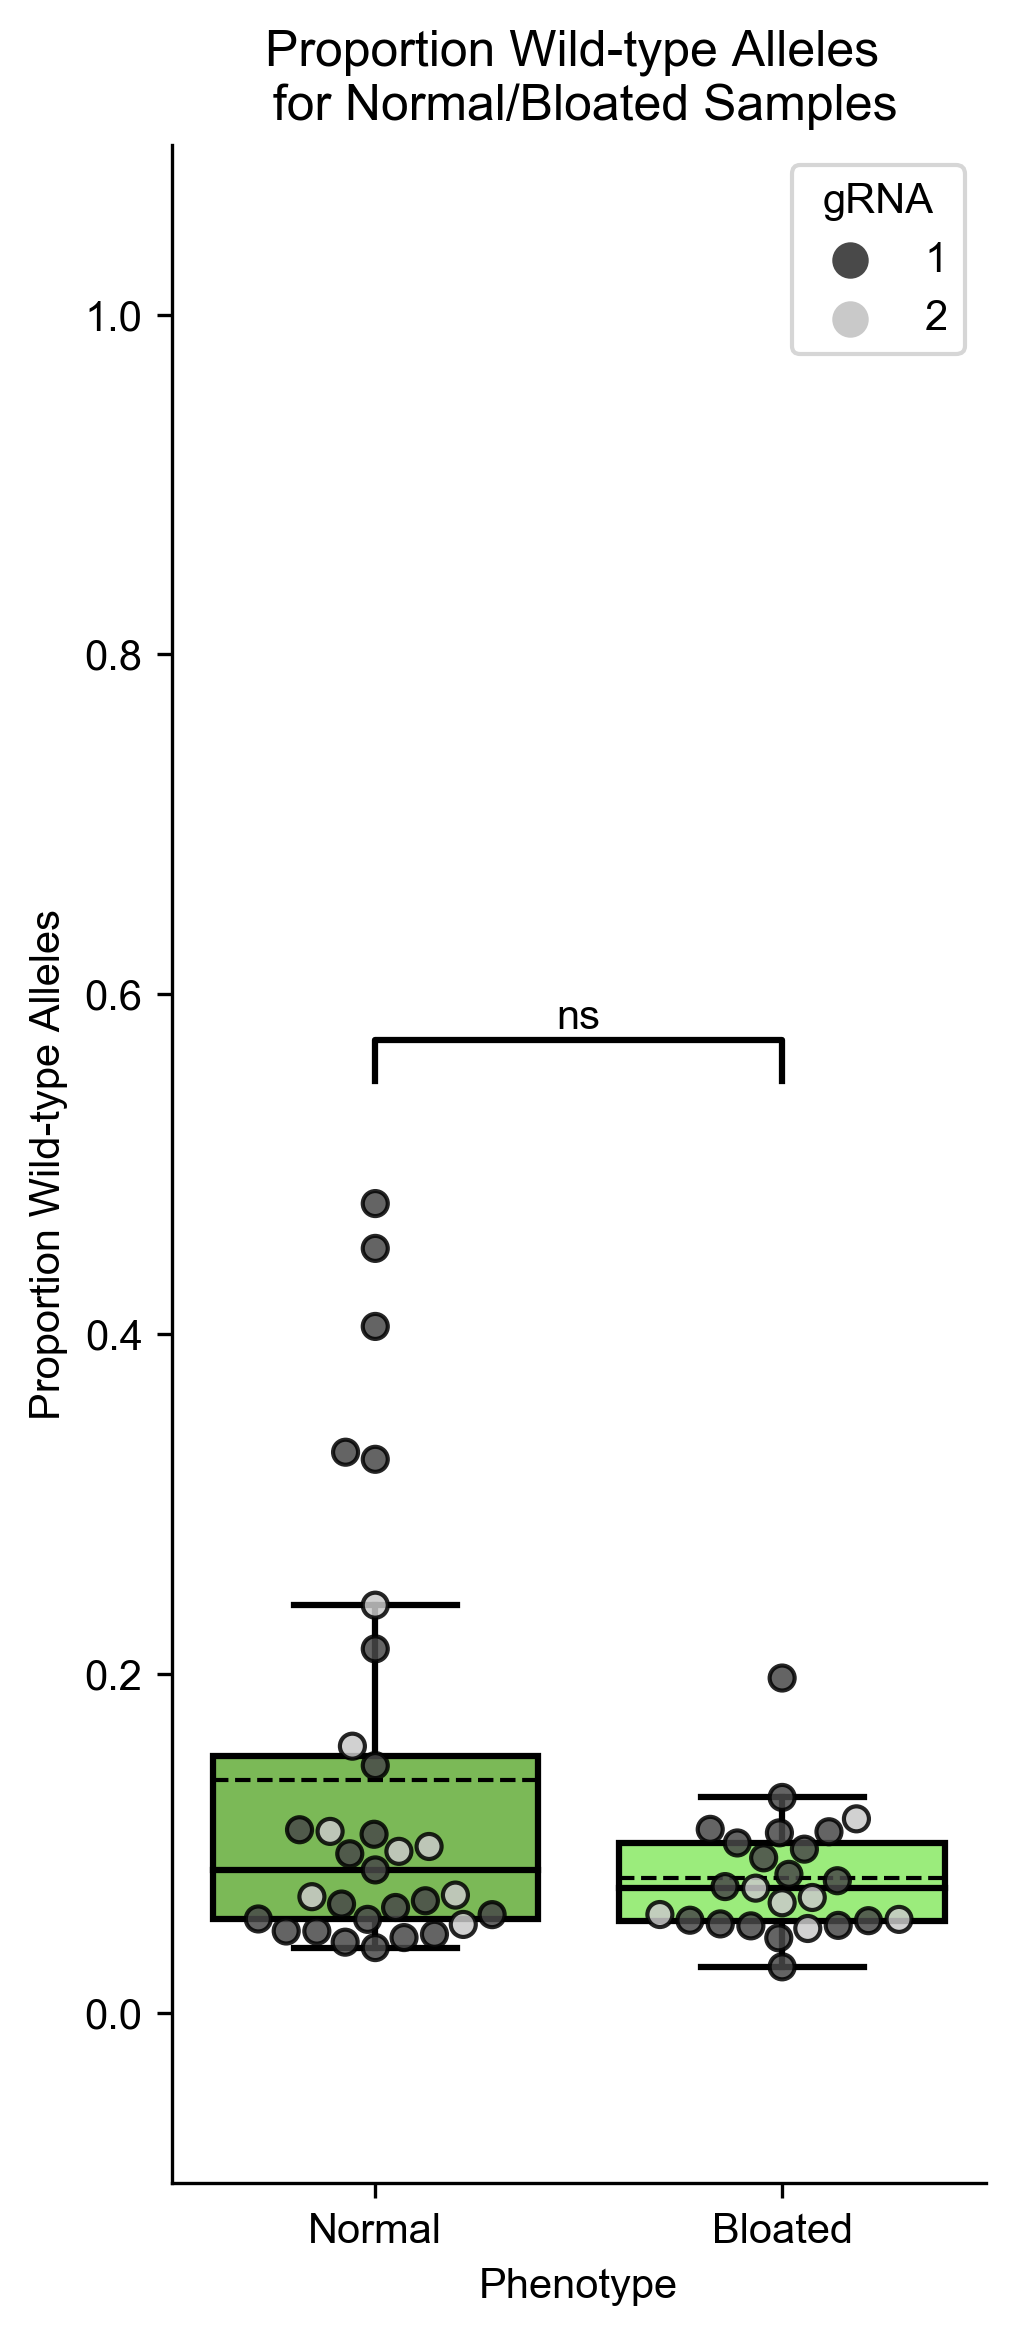

In [140]:
box_strip_plot(["Normal", "Bloated"], "Wild-type", phenotype_metadata_csv, grna_metadata_csv, sns.color_palette(["#77C947", "#92FF69"]), True)

/Users/David/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


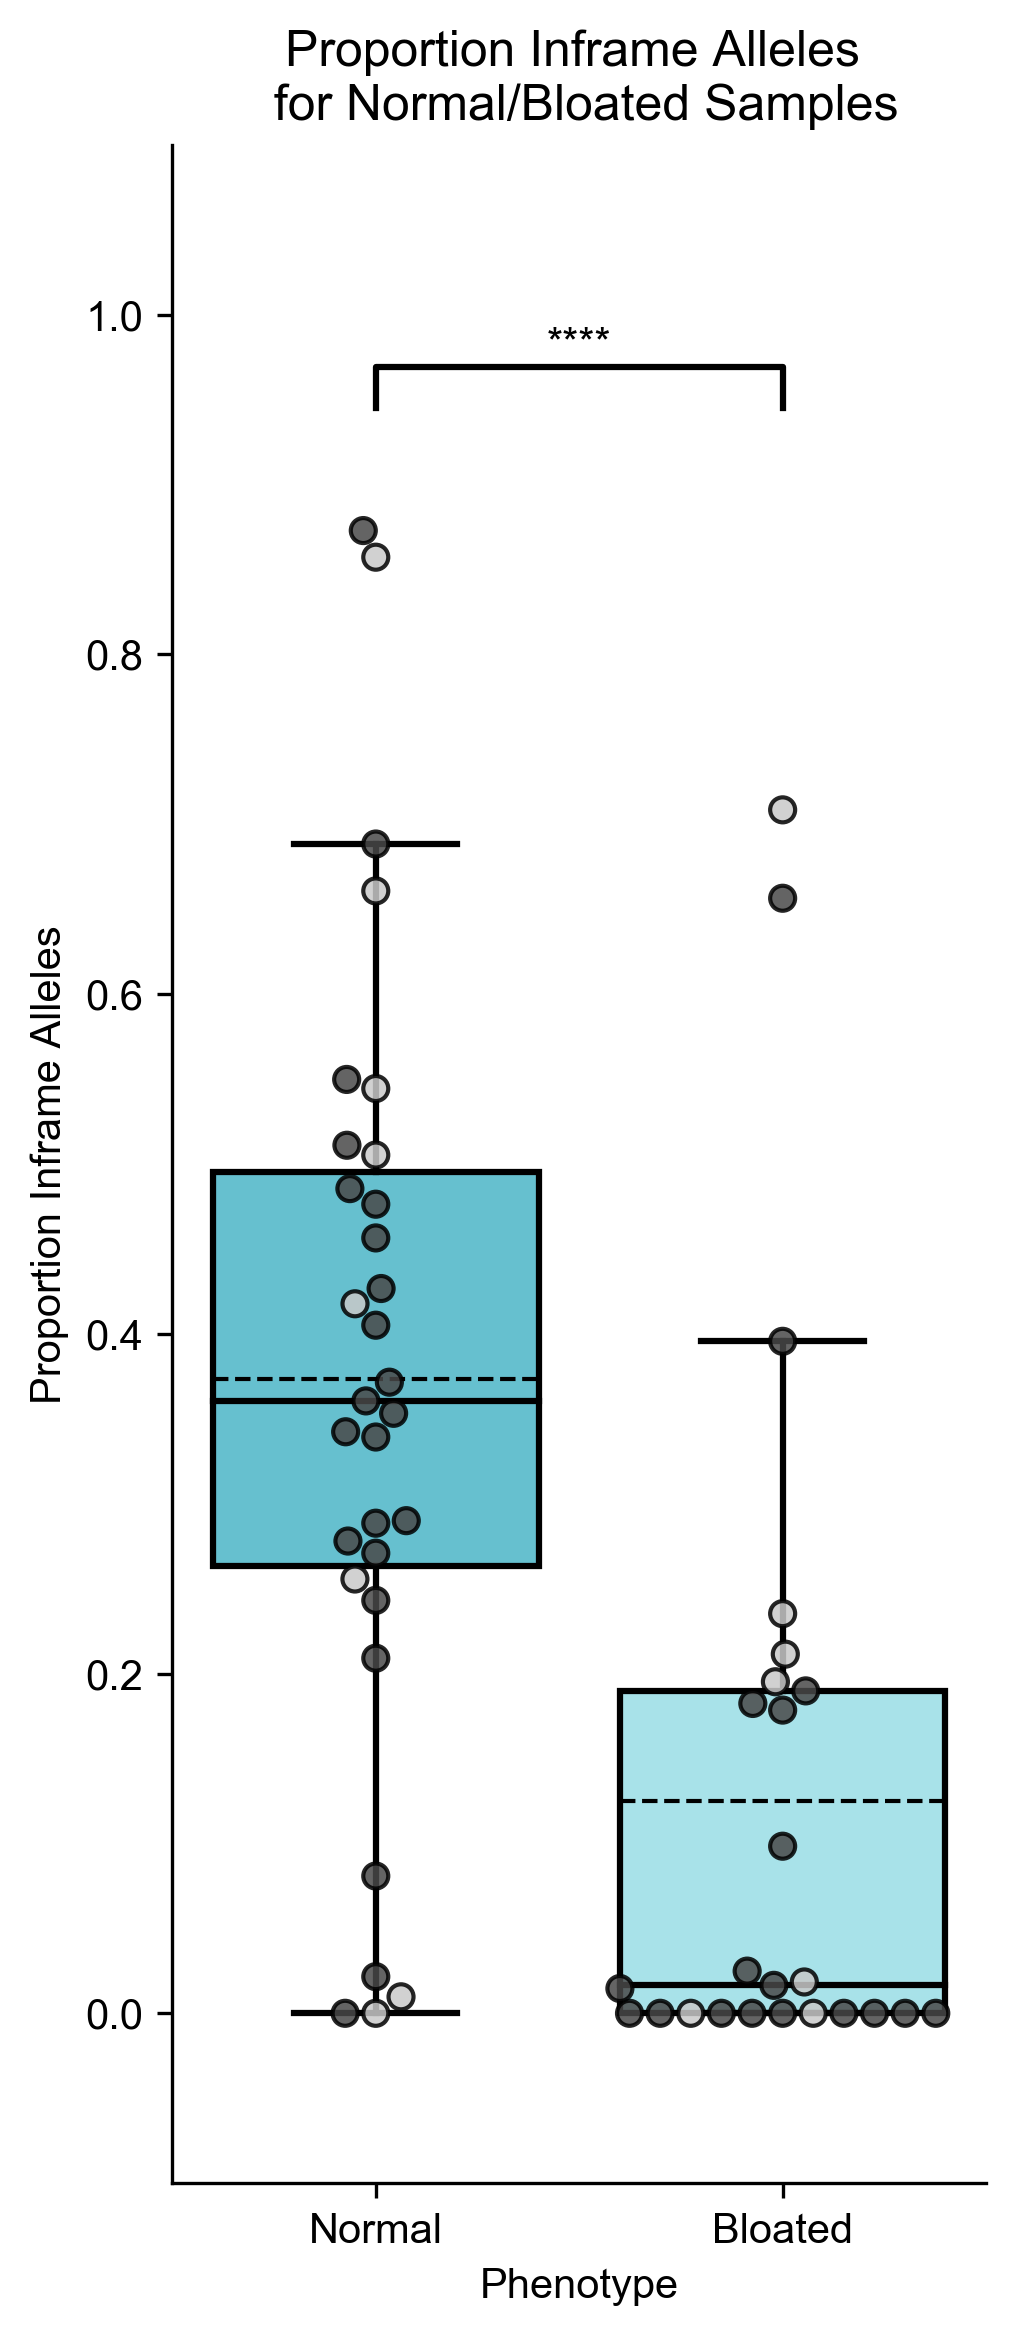

In [135]:
box_strip_plot(["Normal", "Bloated"], "Inframe", phenotype_metadata_csv, grna_metadata_csv, sns.color_palette(["#55CDE0", "#9DEBF4"]), False)

/Users/David/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


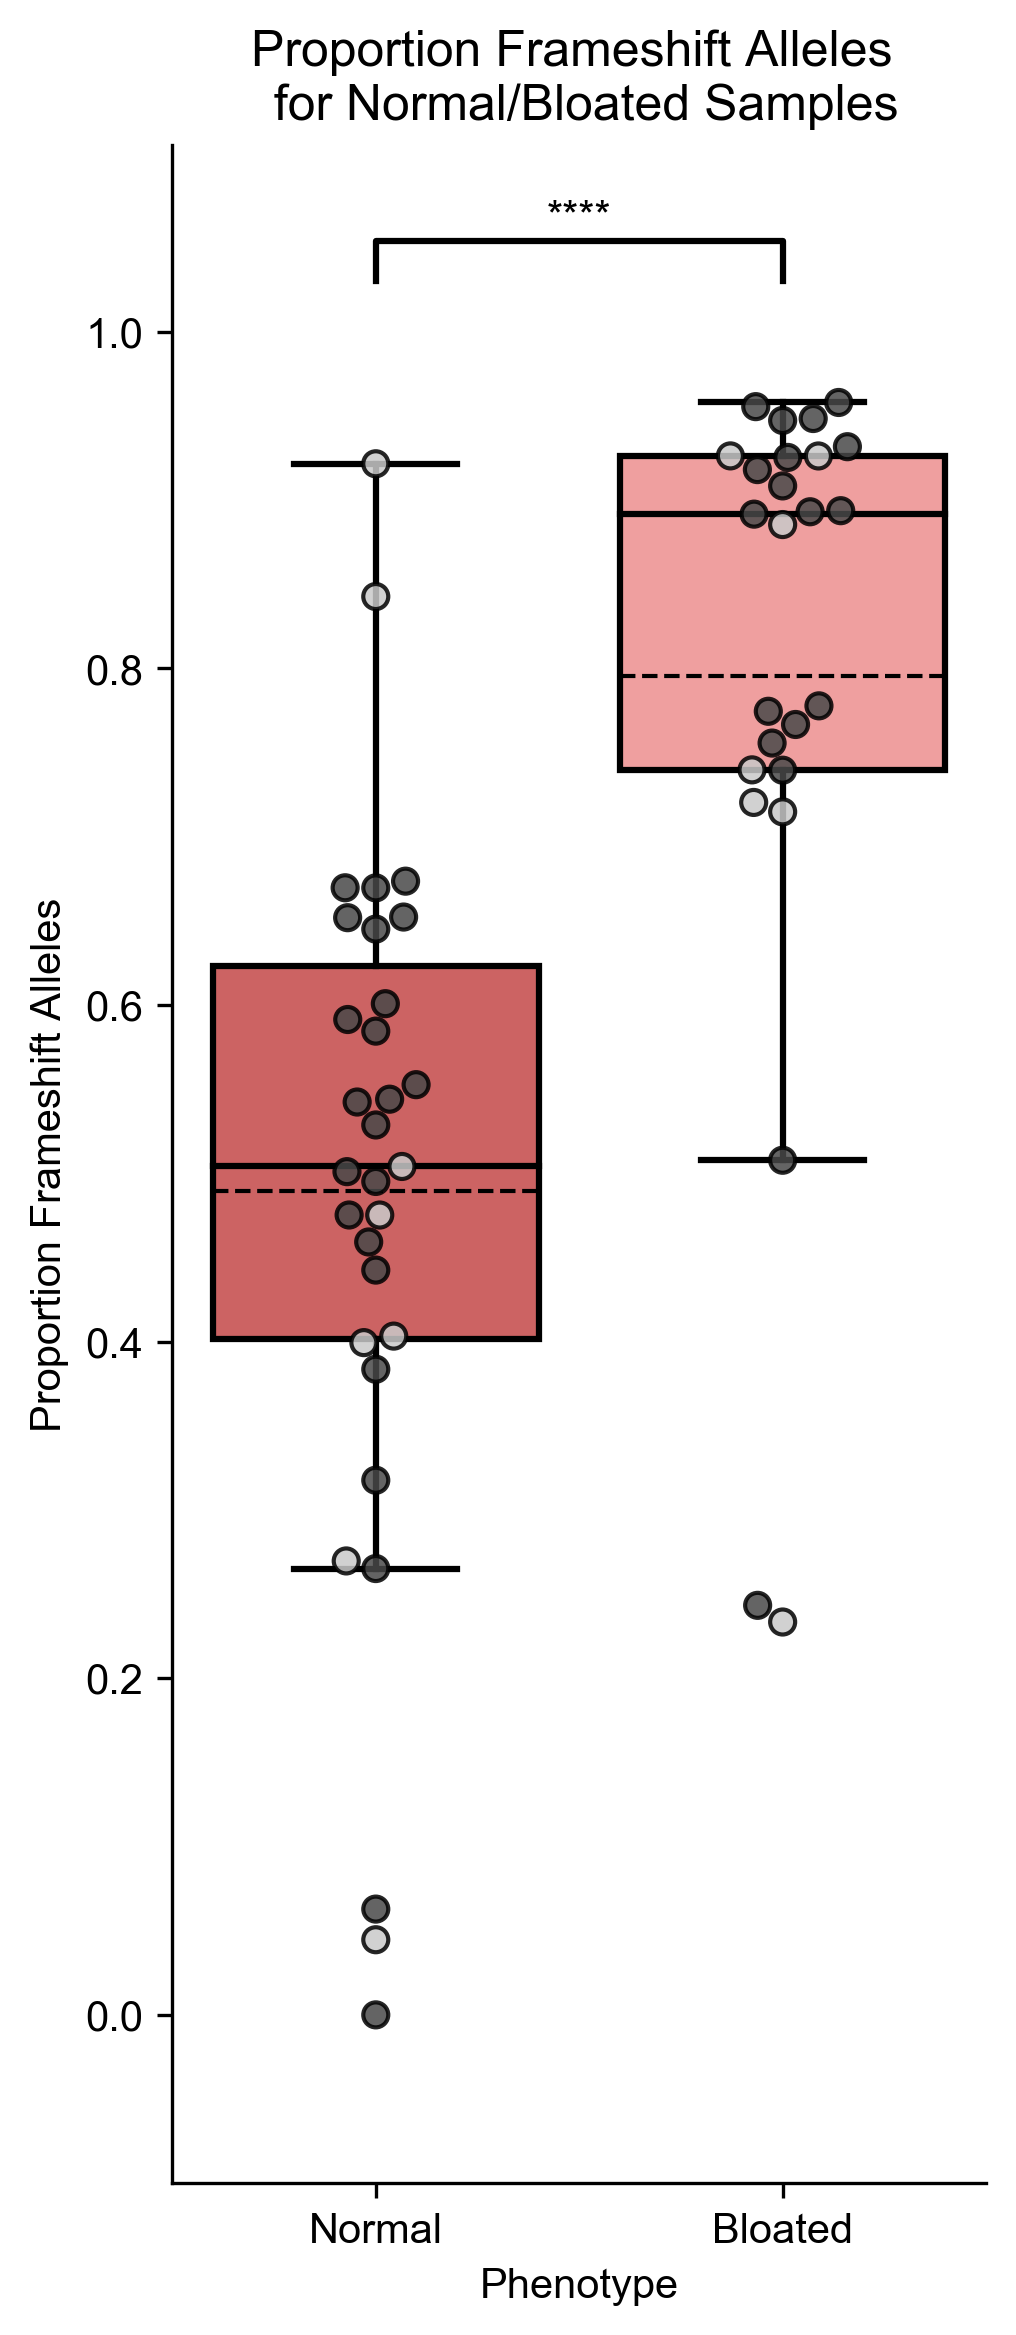

In [136]:
box_strip_plot(["Normal", "Bloated"], "Frameshift", phenotype_metadata_csv, grna_metadata_csv, sns.color_palette(["#DD5252", "#FC9292"]), False)

In [ ]:
sample_phenotype_metadata = pd.read_csv(phenotype_metadata_csv).set_index("Sample Name")
 
normal_sample_names = sample_phenotype_metadata[sample_phenotype_metadata["Phenotype"] == "Normal"].index
bloated_sample_names = sample_phenotype_metadata[sample_phenotype_metadata["Phenotype"] == "Bloated"].index

In [ ]:
def get_aggregate_proportions(sample_names, phenotype, allele_categorization):
    # phenotype: list or string
    # allele_categorization: string
    return all_allele_all_phenotype.loc[pd.IndexSlice[sample_names, phenotype, allele_categorization], ["Area (Base Pairs)"]]["Area (Base Pairs)"]

sum_normal = sum(get_aggregate_proportions(normal_sample_names, "Normal", "Wild-type")) + sum(get_aggregate_proportions(normal_sample_names, "Normal", "Inframe")) +  sum(get_aggregate_proportions(normal_sample_names, "Normal", "Frameshift"))
print("Aggregate proportion normal wild-type: " + str(sum(get_aggregate_proportions(normal_sample_names, "Normal", "Wild-type")) / sum_normal))
print("Aggregate proportion normal inframe: " + str(sum(get_aggregate_proportions(normal_sample_names, "Normal", "Inframe")) / sum_normal))
print("Aggregate proportion normal frameshift: " + str(sum(get_aggregate_proportions(normal_sample_names, "Normal", "Frameshift")) / sum_normal))

sum_normal = sum(get_aggregate_proportions(bloated_sample_names, "Bloated", "Wild-type")) + sum(get_aggregate_proportions(bloated_sample_names, "Bloated", "Inframe")) +  sum(get_aggregate_proportions(bloated_sample_names, "Bloated", "Frameshift"))
print("Aggregate proportion bloated wild-type: " + str(sum(get_aggregate_proportions(bloated_sample_names, "Bloated", "Wild-type")) / sum_normal))
print("Aggregate proportion bloated inframe: " + str(sum(get_aggregate_proportions(bloated_sample_names, "Bloated", "Inframe")) / sum_normal))
print("Aggregate proportion bloated frameshift: " + str(sum(get_aggregate_proportions(bloated_sample_names, "Bloated", "Frameshift")) / sum_normal))

In [ ]:
#Function: takes in sample_name (string) and grouped_samples(DataFrame), returns fold change or proportion wt.
def calculate_value(sample_name, grouped_samples, metric):
    non_wt_peak_areas = 0
    wt_peak_areas = 0
    non_wt_peak_heights = 0
    wt_peak_heights = 0
    
    single_sample = grouped_samples.loc[sample_name, :]
    
    if (False in single_sample.index.values):
        non_wt_peak_areas = single_sample.loc[0, "Area (Base Pairs)"] 
        non_wt_peak_heights = single_sample.loc[0, "Height"] 
    if (True in single_sample.index.values):
        wt_peak_areas = single_sample.loc[1, "Area (Base Pairs)"]
        wt_peak_heights = single_sample.loc[1, "Height"]
        
    all_peak_areas = non_wt_peak_areas + wt_peak_areas
    all_peak_heights = non_wt_peak_heights + wt_peak_heights
    
    fold_change = all_peak_heights / wt_peak_heights
    proportion_wt = wt_peak_areas / all_peak_areas
    
    if metric == "fold change reduction":
        return fold_change
    if metric == "proportion wt":
        return proportion_wt

In [ ]:
grouped_data = all_allele_all_phenotype.groupby(["Sample Name", "WT Peak (T/F)"]).sum()
grouped_data

In [ ]:
sample_names_repeated = [index_tuple[0] for index_tuple in grouped_data.index.values]
sample_names = np.unique(sample_names_repeated)

#weisblat_metric = allNonWT / all
#fold_change = allPeakHeights / WTPeakHeight

proportions_wt = [calculate_value(name, grouped_data, "proportion wt") for name in sample_names]
fold_change_reductions = [calculate_value(name, grouped_data, "fold change reduction") for name in sample_names]
data = {"Sample" : sample_names, "WT Proportion" : proportions_wt, "Fold Change Reductions" : fold_change_reductions}

pd.options.display.min_rows = 200

results = pd.DataFrame(data, columns = ["Sample", "WT Proportion", "Fold Change Reductions"])
results

results.to_csv("non_wt_proportions.csv")